In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
from scipy import stats
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>")) 
import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
data = pd.read_csv('~/Desktop/Capstone/imputed_data_1316.csv')

In [8]:
data.set_index('SEQN',inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 11466 entries, 73557.0 to 93702.0
Columns: 166 entries, RIAGENDR to MCQ160M
dtypes: float64(166)
memory usage: 14.6 MB


In [10]:
features = data.drop('MCQ160M',axis=1)
label = data['MCQ160M']

In [11]:
#split train-test sample
from sklearn.model_selection import train_test_split
#cross-validation param tuning
from sklearn.model_selection import GridSearchCV 
#model performace metrics
from itertools import cycle
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [15]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=10)

##### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty = 'l1', class_weight = 'balanced',solver='liblinear')

In [16]:
#Train default
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

accuracy is 0.7013949433304272
recall is [0.71176471 0.61811024]


0.7327292728114869

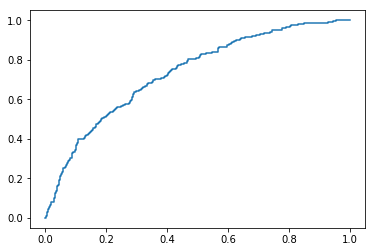

In [18]:
#Default Performance
y_pred_logreg = logreg.predict(x_test)
acc_logreg= logreg.score(x_test, y_test)
y_pred_logreg = logreg.predict(x_test)
recall_logreg = recall_score(y_test, y_pred_logreg, average=None)
print('accuracy is', acc_logreg)
print('recall is', recall_logreg)
y_score_logreg = logreg.decision_function(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_logreg)
plt.plot(fpr,tpr)
metrics.auc(fpr,tpr)

In [ ]:
#Train CV
param_ = {'C':[0.0001,0.001,0.01,0.1,0.5,1.0]}
cv_lr = GridSearchCV(logreg, param_grid = param_, scoring='roc_auc',cv=5)
cv_lr.fit(x_train, y_train)

In [ ]:
#CV performace
plt.plot(list(param_.values())[0],cv_lr.cv_results_['mean_test_score'],label='test')
plt.plot(list(param_.values())[0],cv_lr.cv_results_['mean_train_score'],label='train')
plt.legend()
plt.xscale('log')

##### Linear SVC

In [19]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(class_weight='balanced',penalty='l1',dual=False)

In [20]:
#Train default
lsvc.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

accuracy is 0.6992153443766347
recall is [0.70784314 0.62992126]


0.7376659719005711

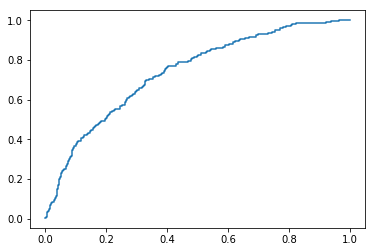

In [21]:
#Default Performance
acc_lsvc= lsvc.score(x_test, y_test)
y_pred_lsvc = lsvc.predict(x_test)
recall_lsvc = recall_score(y_test, y_pred_lsvc, average=None)
print('accuracy is', acc_lsvc)
print('recall is', recall_lsvc)
y_score = lsvc.decision_function(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
metrics.auc(fpr,tpr)

In [ ]:
#Train CV
param_ = {'C':[0.0001,0.001,0.01,0.1,0.5,1.0]}
cv_lsvc = GridSearchCV(lsvc, param_grid = param_, scoring='roc_auc',cv=5)
cv_lsvc.fit(x_train, y_train)

In [ ]:
#CV performace
plt.plot(list(param_.values())[0],cv_lsvc.cv_results_['mean_test_score'],label='test')
plt.plot(list(param_.values())[0],cv_lsvc.cv_results_['mean_train_score'],label='train')
plt.legend()
plt.xscale('log')

##### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')

In [24]:
#Train default RF
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

accuracy is 0.8827375762859634
recall is [0.99166667 0.00787402]


0.6205602516597191

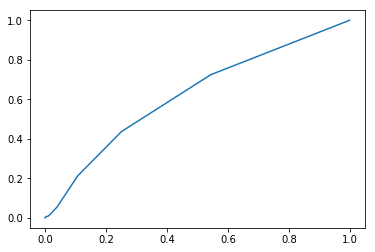

In [26]:
#Default Performance
acc_rf= rf.score(x_test, y_test)
y_pred_rf = rf.predict(x_test)
recall_rf = recall_score(y_test, y_pred_rf, average=None)
print('accuracy is', acc_rf)
print('recall is', recall_rf)
y_score = rf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
metrics.auc(fpr,tpr)

In [35]:
#define 2-D tuning result plot function
def cv_result_plot(results,x_axis,y_axis,param1, param2, groupby_):
    result_table = pd.DataFrame(results)
    summary_table = result_table[['params', 'mean_test_score','mean_train_score','rank_test_score']]
    fig,ax = plt.subplots()
    result_table[param1] = [p[param1] for p in results['params']]
    result_table[param2] = [p[param2] for p in results['params']]
    
    result_table.groupby(groupby_).plot(x=x_axis, y=y_axis, sharex= True, ax=ax)
    ax.legend(list(result_table.groupby(groupby_).groups.keys()), loc=2)
    return ax, summary_table

In [29]:
#Train CV
param_ = {'max_depth':[200,300,500],'n_estimators':[200,400,600,800,1000]}
cv_rf = GridSearchCV(rf, param_grid = param_, scoring='roc_auc',cv=5)
cv_rf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [200, 300, 500], 'n_estimators': [200, 400, 600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f61c55c278>,
                                       params  mean_test_score  \
 0    {'max_depth': 200, 'n_estimators': 200}         0.729990   
 1    {'max_depth': 200, 'n_estimators': 400}         0.733760   
 2    {'max_depth': 200, 'n_estimators': 600}         0.737487   
 3    {'max_depth': 200, 'n_estimators': 800}         0.737229   
 4   {'max_depth': 200, 'n_estimators': 1000}         0.737230   
 5    {'max_depth': 300, 'n_estimators': 200}         0.726392   
 6    {'max_depth': 300, 'n_estimators': 400}         0.734864   
 7    {'max_depth': 300, 'n_estimators': 600}         0.732100   
 8    {'max_depth': 300, 'n_estimators': 800}         0.736542   
 9   {'max_depth': 300, 'n_estimators': 1000}         0.736610   
 10   {'max_depth': 500, 'n_estimators': 200}         0.726292   
 11   {'max_depth': 500, 'n_estimators': 400}         0.729984   
 12   {'max_depth': 500, 'n_estimators': 600}         0.735377   
 13   {'max_depth

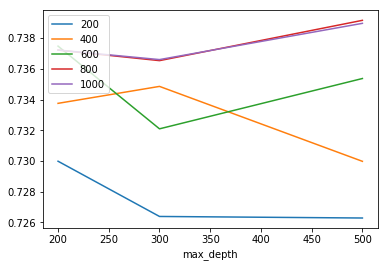

In [36]:
#CV performace
cv_result_plot(cv_rf.cv_results_,'max_depth','mean_test_score','max_depth', 'n_estimators', 'n_estimators')

##### Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
boo = GradientBoostingClassifier()

In [39]:
boo.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

accuracy is 0.8879686137750654
recall is [0.99754902 0.00787402]


0.74294040450826

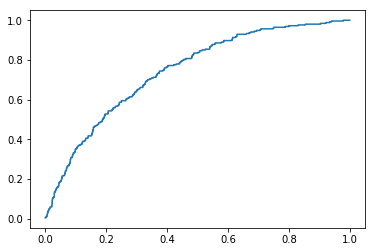

In [40]:
#Default Pebooormance
acc_boo= boo.score(x_test, y_test)
y_pred_boo = boo.predict(x_test)
recall_boo = recall_score(y_test, y_pred_boo, average=None)
print('accuracy is', acc_boo)
print('recall is', recall_boo)
y_score = boo.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
metrics.auc(fpr,tpr)

In [51]:
#Train CV
param_ = {'max_depth':[2,3,4],'n_estimators':[100,200,400]}
cv_boo = GridSearchCV(boo, param_grid = param_, scoring='roc_auc',cv=5)
cv_boo.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'n_estimators': [100, 200, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f61c54bb70>,
                                   params  mean_test_score  mean_train_score  \
 0  {'max_depth': 2, 'n_estimators': 100}         0.764265          0.831735   
 1  {'max_depth': 2, 'n_estimators': 200}         0.760380          0.871175   
 2  {'max_depth': 2, 'n_estimators': 400}         0.755773          0.917932   
 3  {'max_depth': 3, 'n_estimators': 100}         0.762534          0.887095   
 4  {'max_depth': 3, 'n_estimators': 200}         0.757075          0.937566   
 5  {'max_depth': 3, 'n_estimators': 400}         0.749351          0.977226   
 6  {'max_depth': 4, 'n_estimators': 100}         0.758998          0.937711   
 7  {'max_depth': 4, 'n_estimators': 200}         0.754343          0.977723   
 8  {'max_depth': 4, 'n_estimators': 400}         0.746580          0.993512   
 
    rank_test_score  
 0                1  
 1                3  
 2                6  
 3                2  
 4                5  
 5     

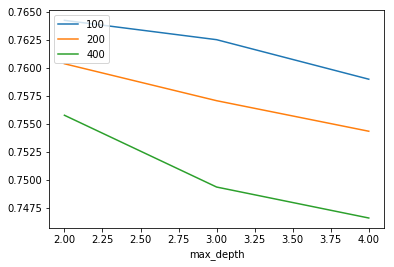

In [52]:
cv_result_plot(cv_boo.cv_results_,'max_depth','mean_test_score','max_depth', 'n_estimators', 'n_estimators')

In [54]:
best_boo = cv_boo.best_estimator_

accuracy is 0.8888404533565823
recall is [0.99803922 0.01181102]


0.7427068859039678

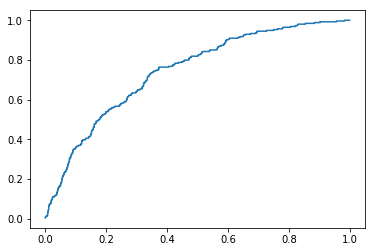

In [59]:
acc_boo= best_boo.score(x_test, y_test)
y_pred_boo = best_boo.predict(x_test)
recall_boo = recall_score(y_test, y_pred_boo, average=None)
print('accuracy is', acc_boo)
print('recall is', recall_boo)
y_score = best_boo.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
metrics.auc(fpr,tpr)

In [56]:
param_ = {'max_depth':[2,3,4],'n_estimators':[80,90,100]}
cv_boo_2 = GridSearchCV(boo, param_grid = param_, scoring='roc_auc',cv=5)
cv_boo_2.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'n_estimators': [80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f61c679d30>,
                                   params  mean_test_score  mean_train_score  \
 0   {'max_depth': 2, 'n_estimators': 80}         0.764642          0.821169   
 1   {'max_depth': 2, 'n_estimators': 90}         0.764497          0.826244   
 2  {'max_depth': 2, 'n_estimators': 100}         0.764302          0.831735   
 3   {'max_depth': 3, 'n_estimators': 80}         0.762682          0.873037   
 4   {'max_depth': 3, 'n_estimators': 90}         0.762542          0.880005   
 5  {'max_depth': 3, 'n_estimators': 100}         0.761425          0.887115   
 6   {'max_depth': 4, 'n_estimators': 80}         0.760795          0.923224   
 7   {'max_depth': 4, 'n_estimators': 90}         0.760077          0.929677   
 8  {'max_depth': 4, 'n_estimators': 100}         0.759307          0.937613   
 
    rank_test_score  
 0                1  
 1                2  
 2                3  
 3                4  
 4                5  
 5     

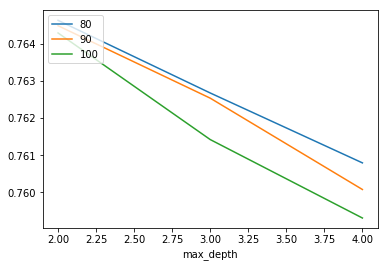

In [57]:
cv_result_plot(cv_boo_2.cv_results_,'max_depth','mean_test_score','max_depth', 'n_estimators', 'n_estimators')

##### Neural Network

accuracy is 0.8892763731473409
recall is [0.99901961 0.00787402]


0.7435772734290566

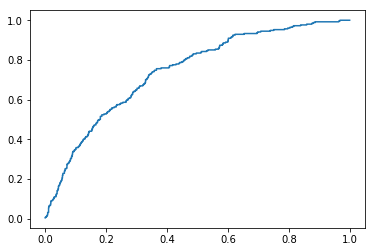

In [60]:
best_boo_2 = cv_boo_2.best_estimator_
acc_boo= best_boo_2.score(x_test, y_test)
y_pred_boo = best_boo_2.predict(x_test)
recall_boo = recall_score(y_test, y_pred_boo, average=None)
print('accuracy is', acc_boo)
print('recall is', recall_boo)
y_score = best_boo_2.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
metrics.auc(fpr,tpr)